In [1]:
from pathlib import Path
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

ROOT = Path("..")
DATA_PROCESSED = ROOT / "data" / "processed" / "db1"
MODELS_DIR     = ROOT / "models" / "db1"
REPORTS_DIR    = ROOT / "reports" / "db1"
for p in [MODELS_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [2]:
# --- Load as before ---
train_npz = DATA_PROCESSED / "dl_train_db1_raw.npz"
val_npz   = DATA_PROCESSED / "dl_val_db1_raw.npz"
test_npz  = DATA_PROCESSED / "dl_test_db1_raw.npz"

ztr = np.load(train_npz, allow_pickle=True)
zva = np.load(val_npz,   allow_pickle=True)
zte = np.load(test_npz,  allow_pickle=True)

Xtr, ytr = ztr["X"], ztr["y"]
Xva, yva = zva["X"], zva["y"]
Xte, yte = zte["X"], zte["y"]
idx_to_label = ztr["idx_to_label"]
n_classes = len(idx_to_label)
print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape, "classes:", n_classes)

# # --- Subsample for CPU demo ---
# # choose a fraction or a fixed number per split
# N_train, N_val, N_test = 2000, 500, 500   # adjust as needed

# rng = np.random.default_rng(seed=0)  # reproducible
# train_idx = rng.choice(len(Xtr), size=min(N_train, len(Xtr)), replace=False)
# val_idx   = rng.choice(len(Xva), size=min(N_val, len(Xva)), replace=False)
# test_idx  = rng.choice(len(Xte), size=min(N_test, len(Xte)), replace=False)

# Xtr, ytr = Xtr[train_idx], ytr[train_idx]
# Xva, yva = Xva[val_idx], yva[val_idx]
# Xte, yte = Xte[test_idx], yte[test_idx]

def stratified_cap(X, y, per_class=200, seed=0):
    rng = np.random.default_rng(seed)
    keep_idx = []
    for c in np.unique(y):
        idx = np.where(y == c)[0]
        if len(idx) == 0: 
            continue
        take = min(per_class, len(idx))
        keep_idx.extend(rng.choice(idx, size=take, replace=False))
    keep_idx = np.array(keep_idx)
    return X[keep_idx], y[keep_idx]

# after loading NPZs:
Xtr, ytr = stratified_cap(Xtr, ytr, per_class=400, seed=0)
Xva, yva = stratified_cap(Xva, yva, per_class=100, seed=1)
Xte, yte = stratified_cap(Xte, yte, per_class=100, seed=2)

# sanity: show class counts
for name, yv in [("train", ytr), ("val", yva), ("test", yte)]:
    vals, cnts = np.unique(yv, return_counts=True)
    print(name, "classes:", len(vals), "min/max per class:", cnts.min(), cnts.max())
    

print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape, "classes:", n_classes)

Train: (312643, 50, 10) Val: (93436, 50, 10) Test: (93476, 50, 10) classes: 23
train classes: 23 min/max per class: 400 400
val classes: 23 min/max per class: 100 100
test classes: 23 min/max per class: 100 100
Train: (9200, 50, 10) Val: (2300, 50, 10) Test: (2300, 50, 10) classes: 23


In [6]:
# (N, T, C) -> (N, C, T) once up front
Xtr_cf = np.transpose(Xtr, (0, 2, 1)).astype(np.float32, copy=False)
Xva_cf = np.transpose(Xva, (0, 2, 1)).astype(np.float32, copy=False)
Xte_cf = np.transpose(Xte, (0, 2, 1)).astype(np.float32, copy=False)

class EMGCFDataset(torch.utils.data.Dataset):
    def __init__(self, X_ct, y):
        self.X = X_ct
        self.y = y.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.tensor(self.y[i], dtype=torch.long)

train_ds = EMGCFDataset(Xtr_cf, ytr)
val_ds   = EMGCFDataset(Xva_cf, yva)
test_ds  = EMGCFDataset(Xte_cf, yte)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=0)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=0)

In [7]:
import math
import torch
from torch import nn

def make_norm(norm_type: str, num_channels: int):
    """Factory for 1D normalization layers."""
    if norm_type.lower() == "bn":
        return nn.BatchNorm1d(num_channels)
    if norm_type.lower() == "gn":
        groups = max(1, min(8, num_channels))
        return nn.GroupNorm(groups, num_channels)
    raise ValueError("norm_type must be 'bn' or 'gn'")

class ConvBlock1D(nn.Module):
    def __init__(self, c_in, c_out, k=5, norm="gn", p_drop=0.1):
        super().__init__()
        pad = k // 2
        self.block = nn.Sequential(
            nn.Conv1d(c_in, c_out, kernel_size=k, padding=pad),
            make_norm(norm, c_out),
            nn.ReLU(inplace=True),
            nn.Conv1d(c_out, c_out, kernel_size=k, padding=pad),
            make_norm(norm, c_out),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
        )
    def forward(self, x):  # (B, C, T)
        return self.block(x)

class CNNLSTM(nn.Module):
    """
    Flexible CNN→LSTM model for EMG windows.
    Input:  (B, C, T)  (channel-first)
    Output: logits (B, n_classes)
    """
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        conv_channels=(64, 128),      # tuple per block (len = n_conv_blocks)
        conv_kernels=(5, 5),          # kernel per block (same length as conv_channels)
        pool_stride=2,                # temporal downsampling after each block
        norm="gn",                    # "bn" or "gn"
        conv_dropout=0.1,
        lstm_hidden=128,
        lstm_layers=2,
        bidir=True,
        lstm_dropout=0.3,
        head_hidden=256,
        head_dropout=0.3,
        temporal_pool="mean",         # "mean", "max", or "last"
    ):
        super().__init__()
        assert len(conv_channels) == len(conv_kernels), "conv_channels and conv_kernels must match length"
        self.temporal_pool = temporal_pool
        self.pool = nn.MaxPool1d(kernel_size=pool_stride) if pool_stride > 1 else nn.Identity()

        # --- CNN stack ---
        c_prev = n_channels
        conv_blocks = []
        for c_out, k in zip(conv_channels, conv_kernels):
            conv_blocks.append(ConvBlock1D(c_prev, c_out, k=k, norm=norm, p_drop=conv_dropout))
            conv_blocks.append(self.pool)   # downsample T each block
            c_prev = c_out
        self.cnn = nn.Sequential(*conv_blocks)

        # --- LSTM over time ---
        # After CNN, we permute to (B, T', C') for LSTM:
        self.bidir = bidir
        self.lstm = nn.LSTM(
            input_size=c_prev, hidden_size=lstm_hidden, num_layers=lstm_layers,
            batch_first=True, dropout=(lstm_dropout if lstm_layers > 1 else 0.0),
            bidirectional=bidir
        )
        lstm_out_dim = lstm_hidden * (2 if bidir else 1)

        # --- Head ---
        self.head = nn.Sequential(
            nn.LayerNorm(lstm_out_dim),
            nn.Linear(lstm_out_dim, head_hidden), nn.ReLU(),
            nn.Dropout(head_dropout),
            nn.Linear(head_hidden, n_classes),
        )

    def forward(self, x):  # x: (B, C, T)
        h = self.cnn(x)                   # (B, C', T')
        h = h.transpose(1, 2)             # (B, T', C') for LSTM
        h, _ = self.lstm(h)               # (B, T', H*dirs)

        if self.temporal_pool == "mean":
            h = h.mean(dim=1)             # (B, H*dirs)
        elif self.temporal_pool == "max":
            h, _ = h.max(dim=1)
        elif self.temporal_pool == "last":
            h = h[:, -1, :]
        else:
            raise ValueError("temporal_pool must be one of {'mean','max','last'}")

        return self.head(h)

In [13]:
n_channels = Xtr.shape[2]    # from your NPZ (N, T, C)
n_classes  = len(idx_to_label)

# Light CPU-friendly defaults: 2 conv blocks → 2-layer BiLSTM
model = CNNLSTM(
    n_channels=n_channels,
    n_classes=n_classes,
    conv_channels=(64, ),
    conv_kernels=(5, ),
    pool_stride=2,
    norm="gn",                # GroupNorm more stable on small batches
    conv_dropout=0.1,
    lstm_hidden=128,
    lstm_layers=2,
    bidir=True,
    lstm_dropout=0.3,
    head_hidden=256,
    head_dropout=0.3,
    temporal_pool="mean",
).to(DEVICE)

sum(p.numel() for p in model.parameters())

690199

In [14]:
# Class weights from training distribution
vals, cnts = np.unique(ytr, return_counts=True)
class_count = np.zeros(n_classes, dtype=np.float32)
class_count[vals] = cnts
weights = 1.0 / (class_count + 1e-6)
weights = torch.tensor(weights / weights.mean(), dtype=torch.float32, device=DEVICE)

criterion = nn.CrossEntropyLoss(weight=weights)  # or nn.CrossEntropyLoss() without weights
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

def run_epoch(model, loader, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)
    total_loss, y_true, y_pred = 0.0, [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        y_true.append(yb.detach().cpu().numpy())
        y_pred.append(logits.argmax(dim=1).detach().cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return total_loss / len(loader.dataset), acc, f1

In [15]:
EPOCHS = 25
PATIENCE = 5
best_val_f1, best_state = -1.0, None
no_improve = 0
hist = []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer)
    va_loss, va_acc, va_f1 = run_epoch(model, val_loader,   optimizer=None)
    hist.append((epoch, tr_loss, tr_acc, tr_f1, va_loss, va_acc, va_f1))
    print(f"Epoch {epoch:02d} | train: loss {tr_loss:.4f} acc {tr_acc:.3f} f1 {tr_f1:.3f} | "
          f"val: loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")

    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)

Epoch 01 | train: loss 2.9477 acc 0.117 f1 0.101 | val: loss 2.8388 acc 0.140 f1 0.092
Epoch 02 | train: loss 2.8020 acc 0.165 f1 0.146 | val: loss 2.8031 acc 0.170 f1 0.133
Epoch 03 | train: loss 2.7369 acc 0.183 f1 0.165 | val: loss 2.8106 acc 0.182 f1 0.146
Epoch 04 | train: loss 2.6876 acc 0.197 f1 0.177 | val: loss 2.7807 acc 0.182 f1 0.155
Epoch 05 | train: loss 2.6382 acc 0.210 f1 0.193 | val: loss 2.8070 acc 0.183 f1 0.161
Epoch 06 | train: loss 2.6102 acc 0.216 f1 0.199 | val: loss 2.7688 acc 0.183 f1 0.148
Epoch 07 | train: loss 2.5521 acc 0.230 f1 0.216 | val: loss 2.7873 acc 0.190 f1 0.165
Epoch 08 | train: loss 2.5188 acc 0.243 f1 0.229 | val: loss 2.8026 acc 0.187 f1 0.161
Epoch 09 | train: loss 2.4661 acc 0.259 f1 0.244 | val: loss 2.7952 acc 0.193 f1 0.165
Epoch 10 | train: loss 2.4148 acc 0.274 f1 0.260 | val: loss 2.8117 acc 0.195 f1 0.176
Epoch 11 | train: loss 2.3692 acc 0.282 f1 0.269 | val: loss 2.8192 acc 0.181 f1 0.171
Epoch 12 | train: loss 2.3205 acc 0.299 f1 

In [16]:
te_loss, te_acc, te_f1 = run_epoch(model, test_loader, optimizer=None)
print(f"Test — loss {te_loss:.4f}  acc {te_acc:.3f}  macro-F1 {te_f1:.3f}")

# Full report
y_true_all, y_pred_all = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(DEVICE)).cpu().numpy()
        y_pred_all.append(np.argmax(logits, axis=1))
        y_true_all.append(yb.numpy())
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

print(classification_report(y_true_all, y_pred_all, zero_division=0))

Test — loss 2.9321  acc 0.173  macro-F1 0.154
              precision    recall  f1-score   support

           0       0.07      0.04      0.05       100
           1       0.21      0.18      0.19       100
           2       0.14      0.16      0.15       100
           3       0.34      0.10      0.16       100
           4       0.22      0.12      0.15       100
           5       0.18      0.07      0.10       100
           6       0.21      0.09      0.13       100
           7       0.11      0.13      0.12       100
           8       0.19      0.13      0.15       100
           9       0.12      0.07      0.09       100
          10       0.08      0.04      0.05       100
          11       0.05      0.01      0.02       100
          12       0.11      0.25      0.15       100
          13       0.18      0.07      0.10       100
          14       0.22      0.25      0.23       100
          15       0.09      0.05      0.06       100
          16       0.10      0.18  

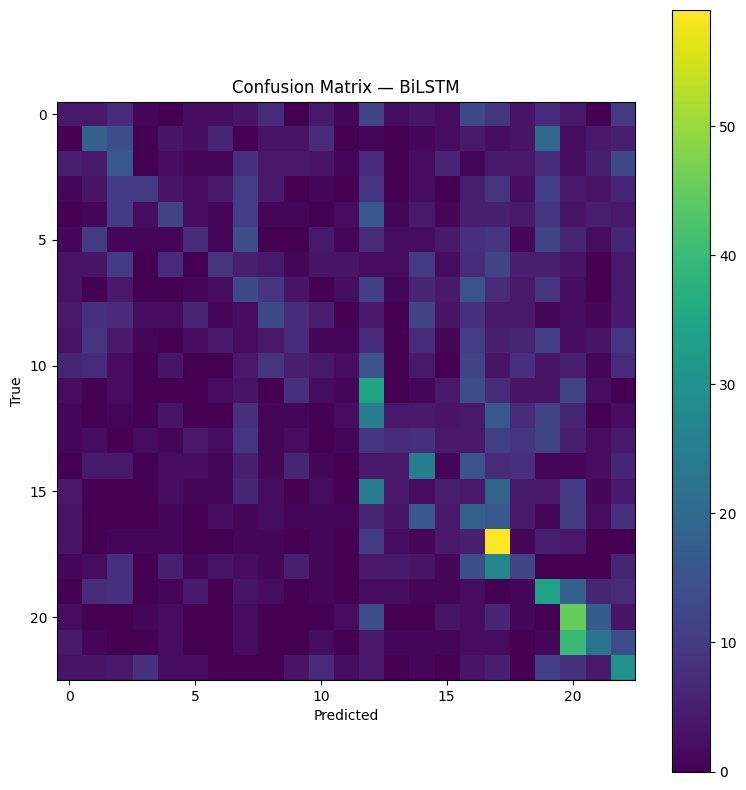

Saved: ../reports/db1/cm_lstm.png


In [17]:
cm = confusion_matrix(y_true_all, y_pred_all)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix — BiLSTM")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.colorbar(im, ax=ax)
plt.tight_layout()

fig_path = REPORTS_DIR / "cm_lstm.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved:", fig_path)

In [18]:
ckpt_path = MODELS_DIR / "lstm_db1.pt"
meta_path = MODELS_DIR / "lstm_db1_meta.npz"

torch.save(model.state_dict(), ckpt_path)
np.savez_compressed(meta_path, n_features=n_features, n_classes=n_classes)

print("Saved model to:", ckpt_path)
print("Saved meta   to:", meta_path)

NameError: name 'n_features' is not defined